In [1]:
import numpy as np
import matplotlib as plt
import math
from graphviz import Digraph
import random

In [2]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._prev = set(_children)
        self._op = _op
        self.label = label
        self._backward = lambda : None

    def __repr__(self):
        return f"Value(data={self.data})"
  
    def __add__(self, other):
        other = other if isinstance(other,Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        return out

    def __mul__(self, other):
        other = other if isinstance(other,Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out
    
    def __pow__(self,other):
        assert isinstance(other,(int,float))
        out = Value(self.data ** other,(self,),f"**{other}")
        def _backward():
            self.grad += other * (self.data ** (other - 1)) * out.grad
        out._backward = _backward
        return out
    
    def __rmul__(self,other):
        return self * other

    def __radd__(self,other):
        return self + other
    
    def __sub__(self,other):
        return self + (-other) 
    def __rsub__(self,other):
        return self - other
    def __neg__(self):
        return self * -1
    def __truediv__(self,other):
        return self * other ** -1
    
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x),_children=(self,),_op='exp')
        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward
        return out
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
        out = Value(data=t,_children=(self,),_op='tanh')
        def _backward():
            self.grad += (1 - t ** 2) * out.grad 
        out._backward = _backward
        return out
    
    def backward(self):
        sorted_nodes = []
        visited = set()
        def topological_sort(n):
            if n not in visited:
                visited.add(n)
                for child in n._prev:
                    topological_sort(child)
                sorted_nodes.append(n)
        self.grad = 1.0
        topological_sort(self)
        for n in reversed(sorted_nodes):
            n._backward()    

In [3]:
a = Value(3)
a

Value(data=3)

In [4]:
b = Value(2)

In [5]:
a+b

Value(data=5)

In [6]:
d = a*b
d.label ='d'
a.label= 'a'
b.label = 'b'

In [7]:
c=Value(2)
a*b+c

Value(data=8)

In [8]:
d._prev,d._op

({Value(data=2), Value(data=3)}, '*')

In [9]:
a = 2.0
b = -3.0
c = 10.0
d = a*b + c
print(d)

4.0


In [10]:
h = 0.0001

# inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
c += h
d2 = a*b + c

print('d1', d1)
print('d2', d2)
print('slope', (d2 - d1)/h)


d1 4.0
d2 4.0001
slope 0.9999999999976694


In [11]:
def build_graph(root):
    nodes,edges = set(),set()
    def build(root):
        if root not in nodes:
            nodes.add(root)
            for child in root._prev:
                edges.add((child,root))
                build(child)
    build(root)
    return nodes,edges

def draw_graph(root):
    graph = Digraph(format='png',directory='net.png',graph_attr={'rankdir':'LR'})
    nodes,edges = build_graph(root)
    for n in nodes:
        uid = str(id(n))
        graph.node(name=uid,label="%s | data %.4f | grad %.4f"%(n.label,n.data,n.grad),shape='record')
        if n._op:
            opid = uid + n._op
            graph.node(name=opid,label=n._op)
            graph.edge(opid,uid)
    for n1,n2 in edges:
        graph.edge(str(id(n1)),str(id(n2))+n2._op)
    return graph

In [12]:
a = Value(2);a.label = 'a'
b = Value(4);b.label = 'b'
x = a + b;x.label='x'
y = Value(7);y.label = 'y'
z = x+y;z.label='z'
build_graph(z)

({Value(data=13), Value(data=2), Value(data=4), Value(data=6), Value(data=7)},
 {(Value(data=2), Value(data=6)),
  (Value(data=4), Value(data=6)),
  (Value(data=6), Value(data=13)),
  (Value(data=7), Value(data=13))})

In [13]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

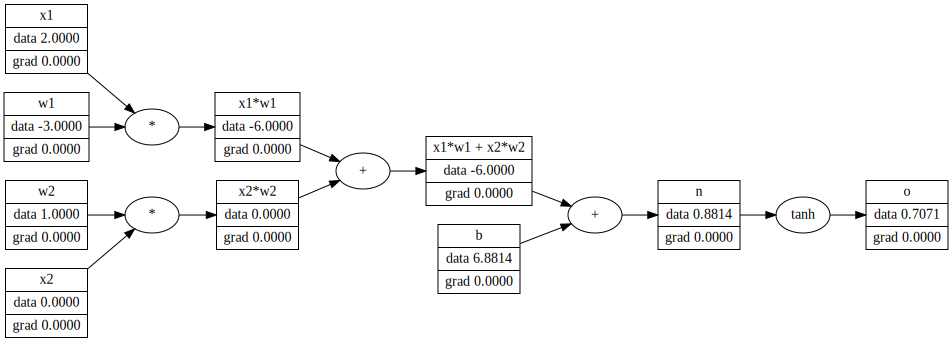

In [14]:
draw_graph(o)

In [15]:
o.backward()

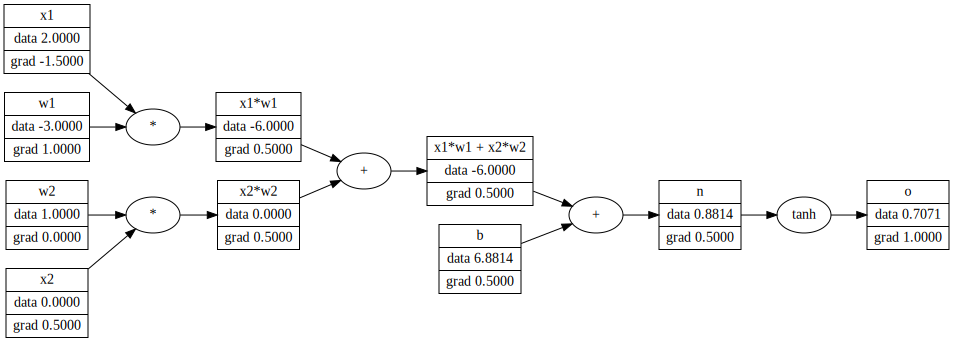

In [16]:
draw_graph(o)

In [17]:
a = Value(2)

In [18]:
a + 2

Value(data=4)

In [19]:
2 + a

Value(data=4)

In [20]:
a.exp()

Value(data=7.38905609893065)

In [21]:
b = Value(2)

In [22]:
a / b

Value(data=1.0)

In [23]:
a - b

Value(data=0)

In [24]:
class Neuron:
    def __init__(self,nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))
    def __call__(self,x):
        n = sum((wi * xi for wi,xi in zip(self.w,x)),self.b)
        o = n.tanh()
        return o
    def parameters(self):
        return self.w + [self.b]
    
class Layer:
    def __init__(self,nin,nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]
    def __call__(self,x):
        out = [n(x) for n in self.neurons]
        return out[0] if len(out)==1 else out
    def parameters(self):
        return [p for n in self.neurons for p in n.parameters()]
            
class MLP:
    def __init__(self,nin,nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i],sz[i+1]) for i in range(len(nouts))]
    
    def __call__(self,x):
        for layer in self.layers:
            x = layer(x)
        return x 
    
    def parameters(self):
        return [p for l in self.layers for p in l.parameters()]

In [25]:
n = Neuron(2)
out = n([2,3])
n.parameters()

[Value(data=0.8233986101166517),
 Value(data=-0.22910079826838237),
 Value(data=-0.5691626763203035)]

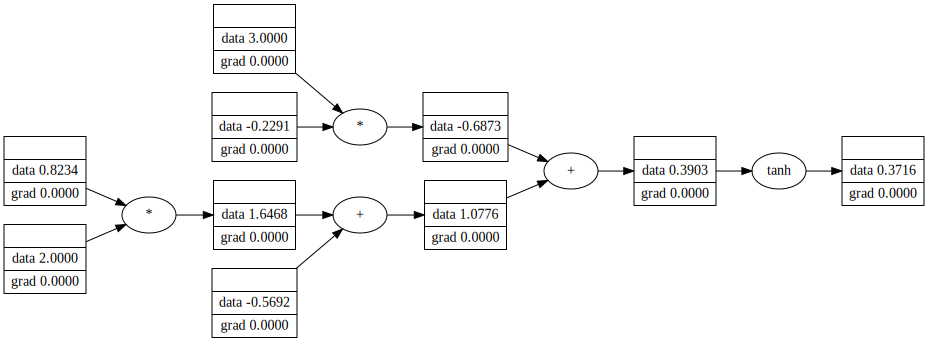

In [26]:
draw_graph(out)

In [27]:
l = Layer(2,3)
l([2,3])
l.parameters()

[Value(data=-0.8477021342176236),
 Value(data=-0.8144571427488692),
 Value(data=0.4385724471495478),
 Value(data=-0.9108692372609433),
 Value(data=0.42335363425509676),
 Value(data=0.19934283047151147),
 Value(data=0.22210752057809247),
 Value(data=0.7487958832707964),
 Value(data=-0.6283961961671862)]

In [28]:
n = MLP(3,[2,1])
X = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
y = [1.0, -1.0, -1.0, 1.0]

In [29]:
ypred = [n(x) for x in X]
loss = sum((yout - ygt)**2 for ygt, yout in zip(y, ypred))

In [30]:
loss.backward()

In [31]:
n.layers[0].neurons[0].w[0].grad

0.49220447124071376

In [32]:
X = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
y = [1.0, -1.0, -1.0, 1.0] # desired targets
n = MLP(3,[8,8,1])

In [33]:
for epoch in range(20):
    y_pred = [n(x) for x in X]
    loss = sum(((yt- yh) ** 2 for yt,yh in zip(y,y_pred)))
    print(f"Epoch : {epoch}, Loss : {loss.data}")
    for param in n.parameters():
        param.grad = 0.0
    loss.backward()
    for param in n.parameters():
        param.data += -0.1 * param.grad
        
    

Epoch : 0, Loss : 1.1988790890253214
Epoch : 1, Loss : 0.018543578252163462
Epoch : 2, Loss : 0.010629600820855768
Epoch : 3, Loss : 0.007852842232162042
Epoch : 4, Loss : 0.006336609393081522
Epoch : 5, Loss : 0.005361954743221691
Epoch : 6, Loss : 0.004675881477831747
Epoch : 7, Loss : 0.004163669897152096
Epoch : 8, Loss : 0.003765037165555367
Epoch : 9, Loss : 0.003445023773382792
Epoch : 10, Loss : 0.0031818584141128795
Epoch : 11, Loss : 0.002961227788556955
Epoch : 12, Loss : 0.002773310905637385
Epoch : 13, Loss : 0.0026111316648032698
Epoch : 14, Loss : 0.002469590602939073
Epoch : 15, Loss : 0.002344868911084724
Epoch : 16, Loss : 0.0022340471663528437
Epoch : 17, Loss : 0.0021348533071236376
Epoch : 18, Loss : 0.0020454912830954568
Epoch : 19, Loss : 0.001964521667109652


In [34]:
y_pred

[Value(data=0.9931713789050386),
 Value(data=-0.9859372383970603),
 Value(data=-0.9598699530263672),
 Value(data=0.9895257617439733)]

In [35]:
out = draw_graph(loss)

In [36]:
type(out)

graphviz.graphs.Digraph

In [37]:
out.render("net", format="pdf")


(process:29584): GLib-GIO-WARNING **: 20:58:57.625: Unexpectedly, UWP app `Microsoft.ScreenSketch_11.2309.16.0_x64__8wekyb3d8bbwe' (AUMId `Microsoft.ScreenSketch_8wekyb3d8bbwe!App') supports 29 extensions but has no verbs

(process:29584): GLib-GIO-WARNING **: 20:58:57.640: Unexpectedly, UWP app `Clipchamp.Clipchamp_2.8.1.0_neutral__yxz26nhyzhsrt' (AUMId `Clipchamp.Clipchamp_yxz26nhyzhsrt!App') supports 41 extensions but has no verbs


'net.png\\net.pdf'